In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras import regularizers
import keras

Using TensorFlow backend.


This is a very slightly cleaned up version of the ipython notebook that I used to train models for the Kaggle competition. I've attempted to add a comment at the top of each cell to say roughly what that cell did. The code is pretty haphazard because a lot of what we did was exploratory. But I feel like it generally reflects the evolution of our models. Given more time, we would do more systematic optimization of our final model (the sentiment sorted, bagged CNN). 

In [2]:
#Import data
train_with_labels = pd.read_csv('training_data.txt',sep=' ')
y = train_with_labels['Label']
train = train_with_labels.drop('Label',1)
test = pd.read_csv('test_data.txt',sep=' ')
joint_set = pd.concat([train,test])

#Further data preprocessing
words = [str(k) for k in joint_set.keys()]


In [3]:
#Count of word appearence. 
#Consider pruning words that are too ubiquitous (and seem to be neutral) or not used enough

word_count = []

for word in words:
    word_count.append((np.sum(train[word]),word))
    #word_count.append((np.sum(test[word]),word))
    #word_count.append((np.sum(joint_set[word]),word))
    
#sorted(word_count)

Text(0.5,1,u'Histogram of review lengths (counting only top 1000 words)')

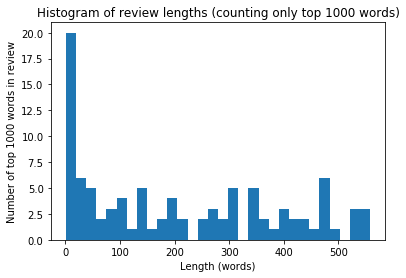

In [4]:
#Check for reviews with no words <- this prob doesn't matter

values = Counter(train.sum(axis=1)).values()
plt.hist(values,bins=30)
plt.xlabel('Length (words)')
plt.ylabel('Number of top 1000 words in review')
plt.title('Histogram of review lengths (counting only top 1000 words)')

In [5]:
#Individual word sentiment - this gets the sentiment for each individual word

def get_sentiment(word, weighted = False):
    '''
    Input: word
    Output: average sentiment (1 for 4/5 star, 0 for 1/2 star of that word)
    If weighted == True: it counts each instance of word as a separate review for the purpose of average sentiment
    '''
    
    labels = np.array(train_with_labels.loc[train_with_labels[word]>0]['Label'])
    
    
    return round(np.mean(labels),3)



word_sentiment = []

for word in words:
    sentiment = get_sentiment(word)
    word_sentiment.append((np.sum(train[word]),sentiment,word))
    
#sorted(word_sentiment)
word_sentiment.sort(key=lambda x: x[1])



Text(0,0.5,u'Word frequency')

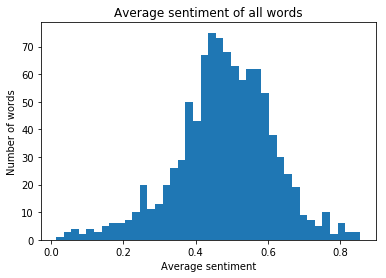

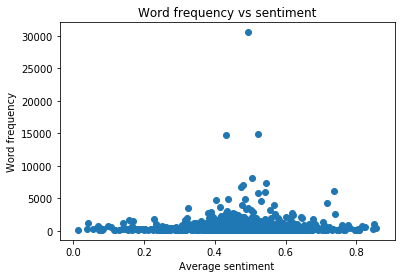

In [6]:
#Make histogram of word sentiments. it might be possible to cut off some of the neutral words
sentiments = np.array([tup[1] for tup in word_sentiment])
freq = [tup[0] for tup in word_sentiment]
ordered_words = [tup[2] for tup in word_sentiment]

plt.hist(sentiments,bins=40)
plt.title('Average sentiment of all words')
plt.xlabel('Average sentiment')
plt.ylabel('Number of words')
plt.figure()
plt.scatter(sentiments,freq)
plt.title('Word frequency vs sentiment')
plt.xlabel('Average sentiment')
plt.ylabel('Word frequency')

In [7]:
#Drop anything between 0.4 and 0.6 in sentiment
neutral_words = np.array(ordered_words)[np.where((sentiments<0.6)&(sentiments>0.4))[0]]
sparse_train = train.drop(neutral_words,axis=1)
sparse_test = test.drop(neutral_words,axis=1)
print np.shape(sparse_train)
sparse_words = sparse_train.keys()
sparse_words

(20000, 407)


Index([u'great', u'love', u'dont', u'even', u'buy', u'well', u'best', u'cd',
       u'album', u'song',
       ...
       u'aspect', u'jump', u'summer', u'brought', u'shock', u'secret',
       u'complaint', u'challeng', u'halloween', u'soni'],
      dtype='object', length=407)

In [8]:
#Function to figure out what words are actually in a given review
def get_review(vector,sparse=True):
    if sparse:
        return sparse_words[np.where(vector != 0)]
    elif sparse==False:
        return np.array(words)[np.where(vector != 0)]

In [ ]:
#The stuff that is commented out with the docstring triple quotes below is the naive classifier

train_indices = np.random.randint(0,len(train),15000)
X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(sparse_train,y,test_size=0.25,random_state = 47)]
'''
#Do a stupid test
stupid_preds = []
for n in range(len(X_train)):
    review = get_review(X_train[n],sparse=True)
    score = np.mean([get_sentiment(i) for i in review])
    if score > 0.5:
        stupid_preds.append(1)
    else:
        stupid_preds.append(0)
        
print (np.array(stupid_preds) == y_train).sum()/float(len(stupid_preds)) 
#This is after pruning the 0.4 to 0.6 words
'''


In [5]:
#Train test split using scikit learn

X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(train,y,test_size=0.25,random_state = 47)]
#X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(sparse_train,y,test_size=0.25,random_state = 47)]


In [ ]:
#First pass at a dense neural network by Dillon

model = Sequential()
model.add(Dense(1000, input_shape=(1000,),kernel_regularizer=regularizers.l1_l2(0.001)))
#model.add(Dense(407, input_shape=(407,),kernel_regularizer=regularizers.l1_l2(0.001)))
model.add(BatchNormalization())
#model.add(Dropout(0.4))
model.add(Activation('relu'))

#model.add(Dense(100))
#model.add(Dropout(0.4))
#model.add(Activation('relu'))

model.add(Dense(10,kernel_regularizer=regularizers.l1(0.001)))
#model.add(Dropout(0.4))
#model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))


print 'Number of parameters = ',model.count_params()
#model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

print train_acc, test_acc



In [ ]:
#Run this cell for more epochs of training if desired

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

print train_acc, test_acc

In [ ]:
#Summarize the model

for layer in model.layers:
    print layer.name, layer.input_shape, layer.output_shape

In [ ]:
#At this point, Devon had a better performing dense neural net so I switched to that

model = Sequential()
#model.add(BatchNormalization(axis=1, input_shape=(1000,), momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(1000, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(Dropout(0.35))


model.add(Dense(500,kernel_regularizer=regularizers.l1_l2(0.0005)))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(500,kernel_regularizer=regularizers.l1_l2(0.0005)))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(500,kernel_regularizer=regularizers.l1_l2(0.0005)))
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(1))
model.add(Activation('sigmoid'))

print 'Number of parameters = ',model.count_params()
#model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

print train_acc, test_acc
if test_acc > record:
    record = test_acc
    print 'New record: ', test_acc
    print 'Write down what you did'

In [ ]:
#Again for more training epochs

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

print train_acc, test_acc
if test_acc > record:
    record = test_acc
    print 'New record: ', test_acc
    print 'Write down what you did'

In [ ]:
#Test of regularization parameter

test_accs = []
regs = np.linspace(0.00005,0.001,10)
for reg in regs:
    #Devon's code
    print 'testing', reg

    ## Create your own model here given the constraints in the problem
    model = Sequential()
    #model.add(BatchNormalization(axis=1, input_shape=(1000,), momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
    model.add(Dense(1000, input_shape=(1000,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.35))
    
    model.add(Dense(200,kernel_regularizer=regularizers.l1_l2(reg)))
    model.add(Activation('relu'))
    model.add(Dropout(0.35))
 
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print 'Number of parameters = ',model.count_params()
    #model.summary()

    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=6, batch_size=128, validation_data=(X_test, y_test))


    train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test)
    
    test_accs.append((np.max(history.history['val_acc']),np.argmax(history.history['val_acc'])))


In [ ]:
#I didn't include this plot in the final report because I'd have to run the code again
#Also it wasn't the final model we submitted

plt.plot(regs,[t[0] for t in test_accs])
print np.max([t[0] for t in test_accs])

In [ ]:
#Test dropout for the dense neural network. Devon also did a similar test. 
#The network architecture changed from above to here b/c Devon had a better version.

dropouts = np.linspace(0.1,0.95,10)
test_accs_dropout = []
for drop in dropouts:
    #Devon's code
    reg = 0.000156

    ## Create your own model here given the constraints in the problem
    model = Sequential()
    model.add(Dense(986, input_shape=(986,)))
    #model.add(Dense(1000, input_shape=(1000,)))
    model.add(Activation('relu'))
    model.add(Dropout(drop))

    model.add(Dense(200,kernel_regularizer=regularizers.l1_l2(reg)))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(drop))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print 'Number of parameters = ',model.count_params()
    #model.summary()

    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

    #history = model.fit(X_train, y_train, epochs=6, batch_size=128, validation_data=(X_test, y_test))
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


    train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test)
    
    test_accs_dropout.append((np.max(history.history['val_acc']),np.argmax(history.history['val_acc'])))


In [ ]:
plt.plot(dropouts,[t[0] for t in test_accs_dropout])
print np.max([t[0] for t in test_accs_dropout])
print dropouts[np.argmax([t[0] for t in test_accs_dropout])]

In [ ]:
#Testing neural nets on the dataset with reduced dimensions (407 words instead of 1000)

#Drop anything between 0.4 and 0.6 in sentiment
#neutral_words = np.array(ordered_words)[np.where((sentiments<0.55)&(sentiments>0.45))[0]]
common_words = np.array(ordered_words)[np.where((np.array(freq) > 3000)&(sentiments<0.55)&(sentiments > 0.45))]

#sparse_train = train.drop(neutral_words,axis=1)
#sparse_test = test.drop(neutral_words,axis=1)
sparse_train = train.drop(common_words,axis=1)
sparse_test = train.drop(common_words,axis=1)

print np.shape(sparse_train)
sparse_words = sparse_train.keys()
sparse_words

#X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(train,y,test_size=0.25,random_state = 47)]
X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(sparse_train,y,test_size=0.25,random_state = 47)]


In [6]:
#Organizing the sentiment of words into a pandas table for easy reference

sentiment_table = pd.DataFrame(word_sentiment)
sentiment_table = sentiment_table.set_index(2)
sentiment_table.loc['refund'][1]

0.014

In [17]:
#One more round at regular neural net - this one didn't do too great


## Create your own model here given the constraints in the problem
model = Sequential()
#model.add(Dense(986, input_shape=(986,)))
model.add(Dense(1000, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(200,kernel_regularizer=regularizers.l1_l2(reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(drop))

model.add(Dense(1))
model.add(Activation('sigmoid'))

print 'Number of parameters = ',model.count_params()
#model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

#history = model.fit(X_train, y_train, epochs=6, batch_size=128, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)


Number of parameters =  1202201
Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 4s 242us/step - loss: 2.4873 - acc: 0.7685 - val_loss: 1.2577 - val_acc: 0.8208
Epoch 2/10
15000/15000 [==============================] - 3s 230us/step - loss: 0.8447 - acc: 0.8509 - val_loss: 0.6726 - val_acc: 0.8268
Epoch 3/10
15000/15000 [==============================] - 3s 227us/step - loss: 0.5173 - acc: 0.8752 - val_loss: 0.5516 - val_acc: 0.8398
Epoch 4/10
15000/15000 [==============================] - 3s 230us/step - loss: 0.4245 - acc: 0.8962 - val_loss: 0.5575 - val_acc: 0.8468
Epoch 5/10
15000/15000 [==============================] - 5s 326us/step - loss: 0.3654 - acc: 0.9255 - val_loss: 0.5583 - val_acc: 0.8492
Epoch 6/10
15000/15000 [==============================] - 3s 227us/step - loss: 0.3140 - acc: 0.9402 - val_loss: 0.7206 - val_acc: 0.8156
Epoch 7/10
15000/15000 [==============================] - 3s 230us/step - loss: 0.2640 - ac

In [18]:
#Try a CNN...

#Reshuffle the data columns
sorted_train = np.array(train[np.array(sentiment_table.index)])
sorted_test = np.array(test[np.array(sentiment_table.index)])

X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(sorted_train,y,test_size=0.25,random_state = 47)]

# we must reshape the X data (add a channel dimension)
X_train = X_train.reshape(tuple(list(X_train.shape)+[1]))
X_test = X_test.reshape(tuple(list(X_test.shape)+[1]))

#print np.shape(X_train)


dropouts = np.linspace(0.1,0.95,20)
test_accs_dropout = []
for drop in dropouts:    
    model = Sequential()
    model.add(Conv1D(8, kernel_size=3, padding='same',input_shape=(1000,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(drop))

    model.add(Conv1D(8, kernel_size=3, padding='same'))
    model.add(Conv1D(8, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(drop))

    model.add(Flatten())
    model.add(Dense(24))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print 'Number of parameters = ',model.count_params()

    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
    train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

    print train_acc, test_acc
    
    test_accs_dropout.append((np.max(history.history['val_acc']),np.argmax(history.history['val_acc'])))




Number of parameters =  48481
Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 4s 292us/step - loss: 0.4044 - acc: 0.8229 - val_loss: 0.3765 - val_acc: 0.8368
Epoch 2/10
15000/15000 [==============================] - 5s 361us/step - loss: 0.3545 - acc: 0.8477 - val_loss: 0.3496 - val_acc: 0.8518
Epoch 3/10
15000/15000 [==============================] - 4s 273us/step - loss: 0.3448 - acc: 0.8521 - val_loss: 0.3490 - val_acc: 0.8470
Epoch 4/10
15000/15000 [==============================] - 4s 265us/step - loss: 0.3389 - acc: 0.8547 - val_loss: 0.3596 - val_acc: 0.8426
Epoch 5/10
15000/15000 [==============================] - 4s 271us/step - loss: 0.3273 - acc: 0.8601 - val_loss: 0.3344 - val_acc: 0.8562
Epoch 6/10
15000/15000 [==============================] - 4s 265us/step - loss: 0.3183 - acc: 0.8607 - val_loss: 0.3512 - val_acc: 0.8484
Epoch 7/10
15000/15000 [==============================] - 4s 269us/step - loss: 0.3159 - acc:

Epoch 2/10
15000/15000 [==============================] - 5s 357us/step - loss: 0.3728 - acc: 0.8414 - val_loss: 0.3552 - val_acc: 0.8496
Epoch 3/10
15000/15000 [==============================] - 4s 267us/step - loss: 0.3638 - acc: 0.8439 - val_loss: 0.3627 - val_acc: 0.8494
Epoch 4/10
15000/15000 [==============================] - 4s 268us/step - loss: 0.3627 - acc: 0.8476 - val_loss: 0.3516 - val_acc: 0.8506
Epoch 5/10
15000/15000 [==============================] - 4s 271us/step - loss: 0.3614 - acc: 0.8473 - val_loss: 0.3538 - val_acc: 0.8512
Epoch 6/10
15000/15000 [==============================] - 4s 267us/step - loss: 0.3577 - acc: 0.8484 - val_loss: 0.3633 - val_acc: 0.8462
Epoch 7/10
15000/15000 [==============================] - 4s 280us/step - loss: 0.3539 - acc: 0.8457 - val_loss: 0.3509 - val_acc: 0.8518
Epoch 8/10
15000/15000 [==============================] - 4s 290us/step - loss: 0.3514 - acc: 0.8490 - val_loss: 0.3510 - val_acc: 0.8502
Epoch 9/10
15000/15000 [==========

15000/15000 [==============================] - 4s 271us/step - loss: 0.4319 - acc: 0.8080 - val_loss: 0.4498 - val_acc: 0.8430
Epoch 5/10
15000/15000 [==============================] - 4s 274us/step - loss: 0.4270 - acc: 0.8107 - val_loss: 0.4498 - val_acc: 0.8468
Epoch 6/10
15000/15000 [==============================] - 4s 271us/step - loss: 0.4209 - acc: 0.8123 - val_loss: 0.4529 - val_acc: 0.8392
Epoch 7/10
15000/15000 [==============================] - 4s 271us/step - loss: 0.4180 - acc: 0.8139 - val_loss: 0.4417 - val_acc: 0.8428
Epoch 8/10
15000/15000 [==============================] - 4s 259us/step - loss: 0.4114 - acc: 0.8197 - val_loss: 0.4385 - val_acc: 0.8462
Epoch 9/10
15000/15000 [==============================] - 4s 266us/step - loss: 0.4122 - acc: 0.8189 - val_loss: 0.4329 - val_acc: 0.8468
Epoch 10/10
5000/5000 [==============================] - 1s 155us/step
0.851066666635 0.8456
Number of parameters =  48481
Train on 15000 samples, validate on 5000 samples
Epoch 1/10


0.8582
0.1


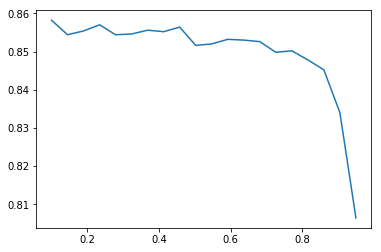

In [19]:
plt.plot(dropouts,[t[0] for t in test_accs_dropout])
print np.max([t[0] for t in test_accs_dropout])
print dropouts[np.argmax([t[0] for t in test_accs_dropout])]

In [7]:
#Now try a CNN with one hot encoding so we can use Dense(2) at the end and softmax

sorted_train = np.array(train[np.array(sentiment_table.index)])
sorted_test = np.array(test[np.array(sentiment_table.index)])

X_train,X_test,y_train,y_test = [np.array(df) for df in train_test_split(sorted_train,y,test_size=0.25,random_state = 47)]

# we must reshape the X data (add a channel dimension)
X_train = X_train.reshape(tuple(list(X_train.shape)+[1]))
X_test = X_test.reshape(tuple(list(X_test.shape)+[1]))

# we'll need to one-hot encode the labels
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

In [55]:
#The code for the CNN. 
ksize = 5
mpool = 2

model = Sequential()
model.add(Conv1D(32, kernel_size=ksize, padding='same',input_shape=(1000,1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=mpool))
model.add(Dropout(0.1))

model.add(Conv1D(8, kernel_size=ksize, padding='same'))
model.add(Conv1D(8, kernel_size=ksize, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=mpool))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

print 'Number of parameters = ',model.count_params()

model.compile(optimizer='adagrad',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

print train_acc, test_acc


Number of parameters =  202510
Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 14s 936us/step - loss: 0.4150 - acc: 0.8219 - val_loss: 0.3482 - val_acc: 0.8500
Epoch 2/10
15000/15000 [==============================] - 13s 877us/step - loss: 0.3451 - acc: 0.8531 - val_loss: 0.3417 - val_acc: 0.8480
Epoch 3/10
15000/15000 [==============================] - 11s 759us/step - loss: 0.3317 - acc: 0.8561 - val_loss: 0.3326 - val_acc: 0.8568
Epoch 4/10
15000/15000 [==============================] - 12s 773us/step - loss: 0.3232 - acc: 0.8603 - val_loss: 0.3308 - val_acc: 0.8536
Epoch 5/10
15000/15000 [==============================] - 13s 868us/step - loss: 0.3143 - acc: 0.8677 - val_loss: 0.3326 - val_acc: 0.8548
Epoch 6/10
15000/15000 [==============================] - 12s 784us/step - loss: 0.3071 - acc: 0.8686 - val_loss: 0.3316 - val_acc: 0.8572
Epoch 7/10
15000/15000 [==============================] - 13s 870us/step - loss: 0.297

In [84]:
#Wrapping up the CNN in a function for easier testing. 
#We'd use this function for a gridsearch if we had more time

def train_cnn(X_train,y_train,X_test,y_test,ksize=5,mpool=2,nepochs=5):
    
    # we must reshape the X data (add a channel dimension)
    X_train = X_train.reshape(tuple(list(X_train.shape)+[1]))
    X_test = X_test.reshape(tuple(list(X_test.shape)+[1]))
    
    # we'll need to one-hot encode the labels
    y_train = keras.utils.np_utils.to_categorical(y_train)
    y_test = keras.utils.np_utils.to_categorical(y_test)
    
    model = Sequential()
    model.add(Conv1D(32, kernel_size=ksize, padding='same',input_shape=(1000,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=mpool))
    model.add(Dropout(0.1))

    model.add(Conv1D(8, kernel_size=ksize, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=mpool))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    print 'Number of parameters = ',model.count_params()

    model.compile(optimizer='adagrad',loss='categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=nepochs, batch_size=128, validation_data=(X_test, y_test))
    train_loss, train_acc = model.evaluate(x=X_train, y=y_train)
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test)

    return (model,train_acc,test_acc)

In [30]:
for layer in model.layers:
    print layer.name, layer.input_shape, layer.output_shape

conv1d_91 (None, 1000, 1) (None, 1000, 32)
activation_127 (None, 1000, 32) (None, 1000, 32)
max_pooling1d_61 (None, 1000, 32) (None, 500, 32)
dropout_59 (None, 500, 32) (None, 500, 32)
conv1d_92 (None, 500, 32) (None, 500, 8)
conv1d_93 (None, 500, 8) (None, 500, 8)
activation_128 (None, 500, 8) (None, 500, 8)
max_pooling1d_62 (None, 500, 8) (None, 250, 8)
dropout_60 (None, 250, 8) (None, 250, 8)
flatten_31 (None, 250, 8) (None, 2000)
dense_67 (None, 2000) (None, 24)
activation_129 (None, 24) (None, 24)
dense_68 (None, 24) (None, 1)
activation_130 (None, 1) (None, 1)


In [28]:
#Stratified K fold cross validation. We used stratified k-fold to have balanced training and test sets
#This cell (which was modified after the fact) actually ended up producing the final model that we submitted

sorted_train = np.array(train[np.array(sentiment_table.index)])
#sorted_test = np.array(test[np.array(sentiment_table.index)])


train_arr,y_arr = np.array(sorted_train),np.array(y)
pred_list = []
test_accs = []

skf = StratifiedKFold(n_splits=20)
s = 0 #running sum of test accuracy
for train_index, test_index in skf.split(train_arr,y_arr):
    X_train, X_test = train_arr[train_index],train_arr[test_index]
    y_train,y_test = y_arr[train_index],y_arr[test_index]
    model,train_acc,test_acc = train_cnn(X_train,y_train,X_test,y_test)
    s+=test_acc
    full_X_test = sorted_test.reshape(tuple(list(sorted_test.shape)+[1]))
    preds = model.predict(full_X_test)
    pred_list.append(preds)
    test_accs.append(test_acc)
    
    
print s/20.0

Number of parameters =  202510
Train on 18999 samples, validate on 1001 samples
Epoch 1/5
18999/18999 [==============================] - 15s 802us/step - loss: 0.4059 - acc: 0.8254 - val_loss: 0.3109 - val_acc: 0.8671
Epoch 2/5
18999/18999 [==============================] - 13s 698us/step - loss: 0.3471 - acc: 0.8493 - val_loss: 0.3008 - val_acc: 0.8681
Epoch 3/5
18999/18999 [==============================] - 15s 775us/step - loss: 0.3318 - acc: 0.8584 - val_loss: 0.2970 - val_acc: 0.8681
Epoch 4/5
18999/18999 [==============================] - 13s 700us/step - loss: 0.3219 - acc: 0.8620 - val_loss: 0.2926 - val_acc: 0.8671
Epoch 5/5
1001/1001 [==============================] - 0s 248us/step
Number of parameters =  202510
Train on 18999 samples, validate on 1001 samples
Epoch 1/5
18999/18999 [==============================] - 23s 1ms/step - loss: 0.3977 - acc: 0.8262 - val_loss: 0.3166 - val_acc: 0.8721
Epoch 2/5
18999/18999 [==============================] - 15s 769us/step - loss: 0.3

Epoch 2/5
19000/19000 [==============================] - 15s 795us/step - loss: 0.3450 - acc: 0.8502 - val_loss: 0.3406 - val_acc: 0.8440
Epoch 3/5
19000/19000 [==============================] - 14s 715us/step - loss: 0.3304 - acc: 0.8570 - val_loss: 0.3355 - val_acc: 0.8470
Epoch 4/5
19000/19000 [==============================] - 15s 809us/step - loss: 0.3206 - acc: 0.8627 - val_loss: 0.3336 - val_acc: 0.8550
Epoch 5/5
1000/1000 [==============================] - 0s 252us/step
Number of parameters =  202510
Train on 19000 samples, validate on 1000 samples
Epoch 1/5
19000/19000 [==============================] - 16s 848us/step - loss: 0.4075 - acc: 0.8213 - val_loss: 0.3238 - val_acc: 0.8550
Epoch 2/5
19000/19000 [==============================] - 14s 757us/step - loss: 0.3452 - acc: 0.8502 - val_loss: 0.3184 - val_acc: 0.8610
Epoch 3/5
19000/19000 [==============================] - 15s 800us/step - loss: 0.3331 - acc: 0.8571 - val_loss: 0.3154 - val_acc: 0.8690
Epoch 4/5
19000/19000 [

In [92]:
#Run final model on all training data - this one didn't do quite as well as the 20 fold bagged CNN

# we must reshape the X data (add a channel dimension)
full_X = sorted_train.reshape(tuple(list(sorted_train.shape)+[1]))
y_arr = np.array(y)

# we'll need to one-hot encode the labels
full_y = keras.utils.np_utils.to_categorical(y_arr)

ksize=2
mpool=2

model = Sequential()
model.add(Conv1D(32, kernel_size=ksize, padding='same',input_shape=(1000,1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=mpool))
model.add(Dropout(0.1))

model.add(Conv1D(8, kernel_size=ksize, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=mpool))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

print 'Number of parameters = ',model.count_params()

model.compile(optimizer='adagrad',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(full_X, full_y, epochs=5, batch_size=128)

Number of parameters =  201318
Epoch 1/5
20000/20000 [==============================] - 13s 669us/step - loss: 0.4127 - acc: 0.8185
Epoch 2/5
20000/20000 [==============================] - 10s 517us/step - loss: 0.3461 - acc: 0.8501
Epoch 3/5
20000/20000 [==============================] - 10s 501us/step - loss: 0.3322 - acc: 0.8574
Epoch 4/5
20000/20000 [==============================] - 12s 583us/step - loss: 0.3183 - acc: 0.8619
Epoch 5/5
20000/20000 [==============================] - 10s 515us/step - loss: 0.3115 - acc: 0.8659


In [95]:
#Get predictions for test data

# we must reshape the X data (add a channel dimension)
full_X_test = sorted_test.reshape(tuple(list(sorted_test.shape)+[1]))

preds = model.predict(full_X_test)

#Write file
f = open('CNN_predictions_single1.csv','w')
f.write('Id,Prediction\n')
for i, pred in enumerate(preds):
    if pred[1] > 0.5:
        f.write(str(i+1)+','+str(1)+'\n')
    else:
        f.write(str(i+1)+','+str(0)+'\n')
f.close()


In [70]:
#Bagging: Average the predictions from the 20 fold cross validated neural net from a few cells up

preds = sum(pred_list)/20.


#Write file
f = open('CNN_predictions5.csv','w')
f.write('Id,Prediction\n')
for i, pred in enumerate(preds):
    if pred[1] > 0.5:
        f.write(str(i+1)+','+str(1)+'\n')
    else:
        f.write(str(i+1)+','+str(0)+'\n')


In [82]:
#Attempting to reweight the various neural nets in our bagging scheme
#This didn't quite work out

modified_weights = np.array(test_accs)-0.834
preds2 = np.zeros(np.shape(pred_list[0]))
for i, weight in enumerate(modified_weights):
    preds2+= ((weight))*pred_list[i]
preds = preds2/np.sum((modified_weights))

In [68]:
(modified_weights*100.)**2

array([  9.69379838,  11.64984434,   5.82829326,   2.29548232,
         2.60817662,  10.32585357,  10.32585357,   0.81      ,
         1.        ,   2.25      ,  12.25      ,   0.        ,
         3.61      ,   2.20488314,   5.22435908,  12.1583802 ,
         1.40324064,   5.6919739 ,   8.91850368,  11.47032474])

In [80]:
#last minute attempt at trying to understand the predictions for which the neural net was struggling
#I'd keep working on this approach if I had more time.

for i, p in enumerate(preds):
    if abs(p[0]-0.5)<0.1:
        print i, p

4 [ 0.57412446  0.42587553]
19 [ 0.59610183  0.40389816]
25 [ 0.43860933  0.56139066]
36 [ 0.52223366  0.47776634]
40 [ 0.50553733  0.49446265]
54 [ 0.41658175  0.58341824]
58 [ 0.4407261   0.55927391]
65 [ 0.47330973  0.52669025]
81 [ 0.43407628  0.5659237 ]
96 [ 0.43218184  0.56781815]
114 [ 0.55719232  0.44280767]
127 [ 0.44888212  0.55111788]
130 [ 0.558782    0.44121798]
153 [ 0.55510093  0.44489905]
155 [ 0.56236746  0.43763253]
162 [ 0.57451953  0.42548046]
167 [ 0.56403531  0.4359647 ]
170 [ 0.47987252  0.52012747]
188 [ 0.41765185  0.58234814]
191 [ 0.42207467  0.57792532]
204 [ 0.48715752  0.51284246]
221 [ 0.44753807  0.55246192]
234 [ 0.48402859  0.51597141]
251 [ 0.48164307  0.51835693]
259 [ 0.53222236  0.46777764]
266 [ 0.42636293  0.57363705]
285 [ 0.497806  0.502194]
292 [ 0.56217923  0.43782077]
297 [ 0.53012633  0.46987368]
298 [ 0.41388909  0.5861109 ]
305 [ 0.50911507  0.49088494]
309 [ 0.55772123  0.44227877]
310 [ 0.51353357  0.48646643]
320 [ 0.51868714  0.48131

4589 [ 0.56132068  0.4386793 ]
4630 [ 0.59551937  0.40448063]
4631 [ 0.5455512   0.45444881]
4680 [ 0.54270885  0.45729114]
4710 [ 0.44357176  0.55642822]
4727 [ 0.42828218  0.57171781]
4738 [ 0.47167851  0.52832149]
4742 [ 0.46012993  0.53987005]
4756 [ 0.41713332  0.58286666]
4763 [ 0.57965378  0.42034619]
4766 [ 0.54282328  0.45717671]
4767 [ 0.55904889  0.44095112]
4778 [ 0.53739301  0.46260699]
4787 [ 0.57339093  0.42660906]
4788 [ 0.51045836  0.48954163]
4798 [ 0.51634428  0.48365571]
4803 [ 0.59793045  0.40206957]
4812 [ 0.50299094  0.49700905]
4813 [ 0.53595644  0.46404354]
4831 [ 0.54934188  0.45065813]
4841 [ 0.41231565  0.58768434]
4850 [ 0.4884595   0.51154053]
4875 [ 0.44470425  0.55529573]
4889 [ 0.53297139  0.4670286 ]
4899 [ 0.44849011  0.55150988]
4900 [ 0.42865956  0.57134043]
4901 [ 0.46368158  0.53631839]
4918 [ 0.55969897  0.44030103]
4930 [ 0.53546673  0.46453327]
4932 [ 0.46874085  0.53125913]
4934 [ 0.48206789  0.51793209]
4953 [ 0.46259917  0.5374008 ]
4961 [ 0